In [1]:
from __future__ import division
%matplotlib inline
import sys 
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io as io
import pickle

import scipy.stats

import itertools

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [2]:
prj_dir = '/Volumes/hoycw_clust/PRJ_Error/'
results_dir = prj_dir+'results/'
fig_type = '.png'
data_dir = prj_dir+'data/'

## Get SBJ List

In [3]:
SBJ_list = 'easy_ieeg'

SBJ_list_fname = prj_dir+'scripts/SGE_SBJ_lists/'+SBJ_list+'.sbj'
SBJ_list_file = open(SBJ_list_fname,'r')
SBJs = SBJ_list_file.readlines()
SBJ_list_file.close()
SBJs = [s.strip('\n') for s in SBJs]

## Load all SBJ data

In [4]:
data = {}
all_ITIs = []
for sbj_ix, sbj in enumerate(SBJs):
    # Load original data
    behav_fname = os.path.join(data_dir,sbj,'03_events',sbj+'_behav.csv')
    data[sbj] = pd.read_csv(behav_fname)
    all_ITIs = np.union1d(all_ITIs,np.unique(data[sbj]['ITI type'].values))
#     if sbj_ix==0:
#         all_ITIs = np.unique(data[sbj]['ITI type'].values)
#     else:
#         all_ITIs = np.concatenate((all_ITIs,np.unique(data[sbj]['ITI type'].values)))

all_ITIs = np.round(np.unique(all_ITIs),decimals=2)
print all_ITIs

[ 0.    0.2   0.4   0.5   0.7   0.85  1.    1.2 ]


/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:6: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
//anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
//anaconda/lib/python2.7/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be removed in 3.0")


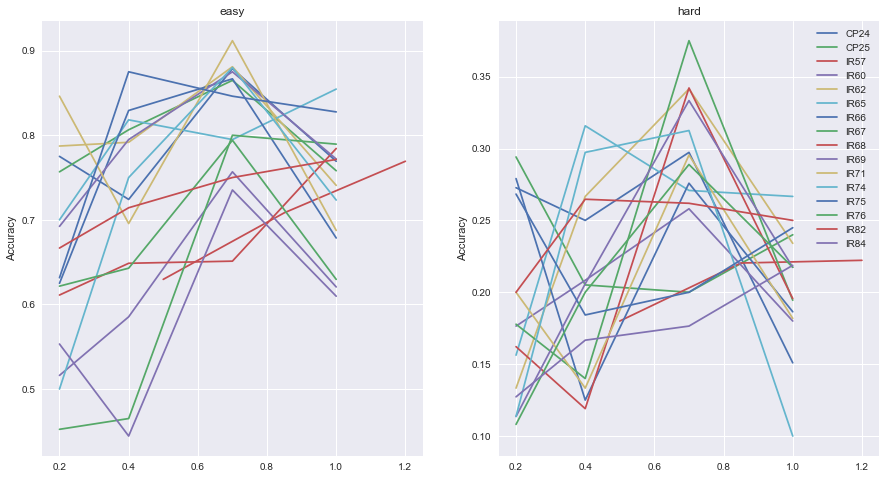

In [5]:
grp_acc = {'easy': {k: [] for k in all_ITIs},
          'hard': {k: [] for k in all_ITIs}}
grp_iti = {sbj: [] for sbj in SBJs}

f, axes = plt.subplots(1,2,figsize=(15,8))
plt.hold(True)
for sbj_ix, sbj in enumerate(SBJs):
    # Compute accuracy per block
    acc = data[sbj]['Hit'].groupby([data[sbj]['Condition'],data[sbj]['ITI type']]).mean()
#     for ix in range(len(data[sbj])):
#         data[sbj].loc[ix,'Accuracy'] = accuracy[data[sbj].loc[ix,'Block'],data[sbj].loc[ix,'Condition']]
    
    grp_iti[sbj] = acc.index.levels[1][acc.index.labels[1]]
    cond_idx = acc.index.labels[0]
    for cond_ix, cond in enumerate(grp_acc.keys()):
        for iti in grp_iti[sbj]:
            grp_acc[cond][np.round(iti,decimals=2)].append(acc[cond,np.round(iti,decimals=2)])
        
        axes[cond_ix].plot(grp_iti[sbj][(cond_idx==cond_ix) & (grp_iti[sbj]>0)],
                           acc.values[(cond_idx==cond_ix) & (grp_iti[sbj]>0)],label=sbj)
    # Compile across SBJs
#     if sbj_ix==0:
#         grp_acc = accuracy
#     else:
#         grp_acc = pd.concat([grp_acc,accuracy])
plt.legend(loc='best')
axes[0].set_title('easy')
axes[0].set_ylabel('Accuracy')
axes[1].set_title('hard')
axes[1].set_ylabel('Accuracy')

In [6]:
# for ix in range(len(accuracy)):
#     print ix, accuracy[ix], accuracy.index.levels[0][accuracy.index.labels[0][ix]]

/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:5: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.


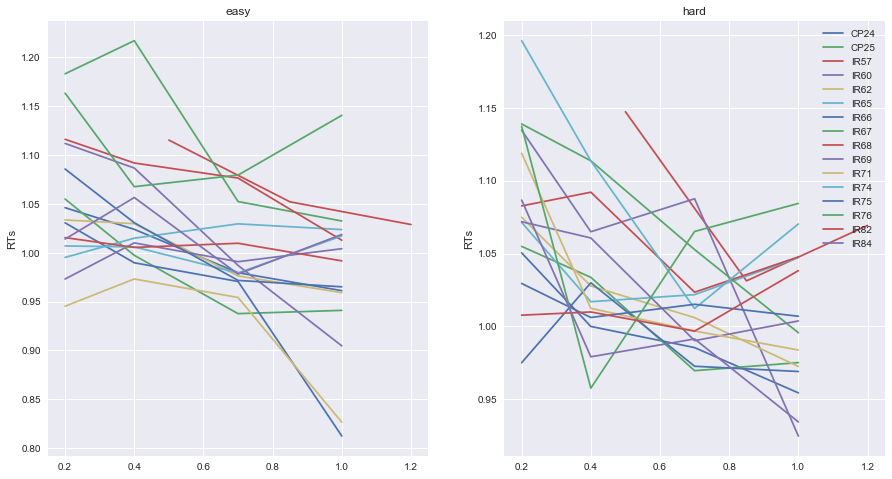

In [7]:
grp_rts = {'easy': {k: [] for k in all_ITIs},
          'hard': {k: [] for k in all_ITIs}}

f, axes = plt.subplots(1,2,figsize=(15,8))
plt.hold(True)
for sbj_ix, sbj in enumerate(SBJs):
    # Compute accuracy per block
    rts = data[sbj]['RT'].groupby([data[sbj]['Condition'],data[sbj]['ITI type']]).mean()
#     for ix in range(len(data[sbj])):
#         data[sbj].loc[ix,'Accuracy'] = accuracy[data[sbj].loc[ix,'Block'],data[sbj].loc[ix,'Condition']]
    
    cond_idx = rts.index.labels[0]
    for cond_ix, cond in enumerate(['easy','hard']):#grp_acc.keys()):
        for iti in grp_iti[sbj]:
            grp_rts[cond][np.round(iti,decimals=2)].append(rts[cond,np.round(iti,decimals=2)])
        
        axes[cond_ix].plot(grp_iti[sbj][(cond_idx==cond_ix) & (grp_iti[sbj]>0)],
                           rts.values[(cond_idx==cond_ix) & (grp_iti[sbj]>0)],label=sbj)
    # Compile across SBJs
#     if sbj_ix==0:
#         grp_acc = accuracy
#     else:
#         grp_acc = pd.concat([grp_acc,accuracy])
plt.legend(loc='best')
axes[0].set_title('easy')
axes[0].set_ylabel('RTs')
axes[1].set_title('hard')
axes[1].set_ylabel('RTs')

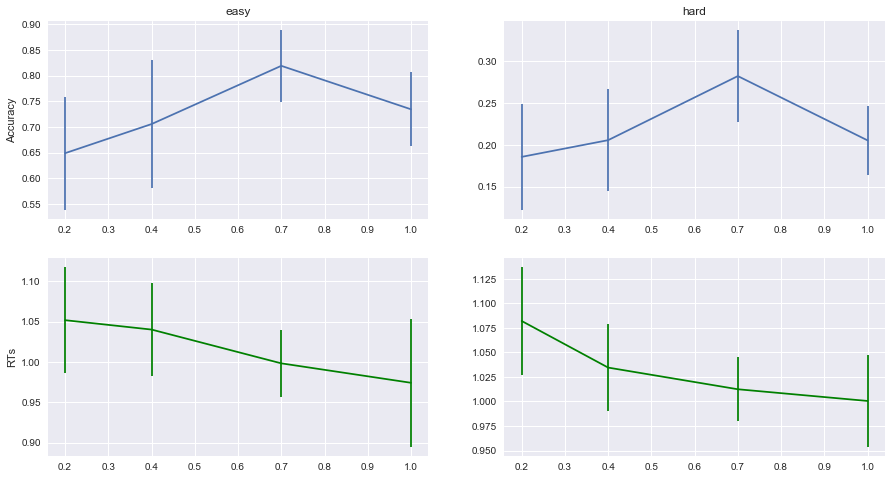

In [27]:
bad_itis = [0,0.5,0.85,1.2]
good_itis = [i not in bad_itis for i in all_ITIs]
# Group plot with error bars
f, axes = plt.subplots(2,2,figsize=(15,8))
for cond_ix, cond in enumerate(['easy', 'hard']):
    axes[0,cond_ix].errorbar(all_ITIs[good_itis],
                             [np.mean(grp_acc[cond][iti]) for iti in all_ITIs if iti not in bad_itis],
                            yerr=[np.std(grp_acc[cond][iti]) for iti in all_ITIs if iti not in bad_itis])
    axes[1,cond_ix].errorbar(all_ITIs[good_itis],
                             [np.mean(grp_rts[cond][iti]) for iti in all_ITIs if iti not in bad_itis],
                            yerr=[np.std(grp_rts[cond][iti]) for iti in all_ITIs if iti not in bad_itis],
                            color='g')
    axes[0,cond_ix].set_title(cond)

axes[0,0].set_ylabel('Accuracy')
axes[1,0].set_ylabel('RTs')


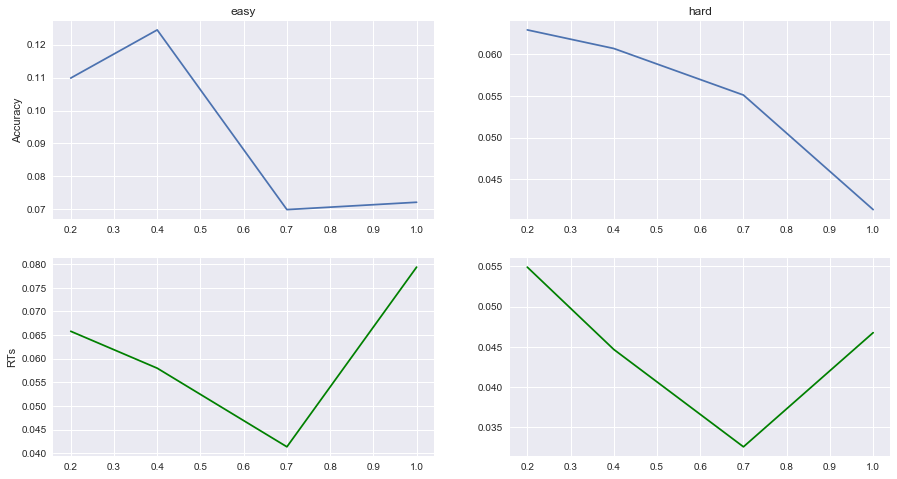

In [28]:
# Standarad Deviation across group plot
f, axes = plt.subplots(2,2,figsize=(15,8))
for cond_ix, cond in enumerate(['easy', 'hard']):
    axes[0,cond_ix].plot(all_ITIs[good_itis],
                             [np.std(grp_acc[cond][iti]) for iti in all_ITIs if iti not in [0,0.5,0.85,1.2]])
    axes[1,cond_ix].plot(all_ITIs[good_itis],
                             [np.std(grp_rts[cond][iti]) for iti in all_ITIs if iti not in [0,0.5,0.85,1.2]],
                        color='g')
    axes[0,cond_ix].set_title(cond)

axes[0,0].set_ylabel('Accuracy')
axes[1,0].set_ylabel('RTs')

# BS below here

In [ ]:
sns.stripplot(data=grp_acc,x=)

In [81]:
tmp1 = data['IR75'].groupby(['Condition','ITI type'])
tmp2 = data['IR57'].groupby(['Condition','ITI type'])
acc1 = tmp1['Hit'].agg(np.mean)
acc2 = tmp2['Hit'].agg(np.mean)

In [83]:
acc12 = pd.concat([acc1,acc2])

In [89]:
type(tmp1)

pandas.core.groupby.DataFrameGroupBy

# FUCK trying to groupby and such, just get arrays of the variables and build a new dataframe!

In [95]:

for ix in range(len(data)):
    data.loc[ix,'Accuracy'] = accuracy[data.loc[ix,'Block'],data.loc[ix,'Condition']]

0.33333333333333331

In [90]:
all_data = data[SBJs[0]]
for sbj in SBJs[1:]:
    all_data = pd.concat([all_data,data[sbj]])

In [92]:
all_acc = all_data['Hit'].groupby([all_data['Condition'],all_data['ITI type']]).mean()



In [93]:
all_acc

Condition  ITI type
easy       0.00        0.333333
           0.50        0.629630
           0.85        0.708333
           1.20        0.769231
hard       0.00        0.000000
           0.50        0.180000
           0.85        0.220339
           1.20        0.222222
Name: Hit, dtype: float64

In [85]:
sns.factorplot(data=acc12,x='ITI type',y='Accuracy',kind='point')

ValueError: Could not interpret input 'ITI type'

##RT and Accuracy Effects by ITI and across post-error

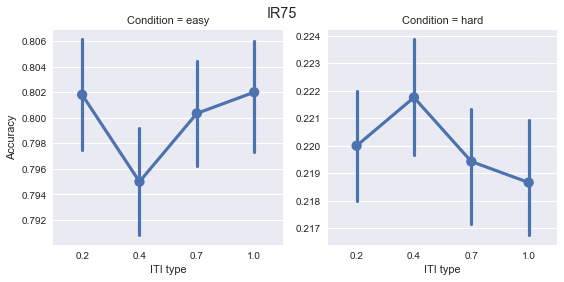

In [57]:
plot = sns.factorplot(data=data,x='ITI type',y='Accuracy',col='Condition',kind='point',sharey=False,
               ci=95);#,order=ITI_plot_order
#plot.set(alpha=0.5)
plt.subplots_adjust(top=0.9)
plot.fig.suptitle(SBJ) # can also get the figure from plt.gcf()

plt.savefig(results_dir+'BHV/accuracy/'+SBJ+'_acc_PE_ITI_hit'+fig_type)